In [1]:
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings
from attention import AttentionLayer
pd.set_option("display.max_colwidth", 200)

warnings.filterwarnings("ignore")
from shutil import copyfile
copyfile(src = "/kaggle/input/attention-py/attention.py", dst = "/kaggle/working/attention.py")

'/kaggle/working/attention.py'

In [3]:
import pandas as pd
data=pd.read_csv("/kaggle/input/cleaned-amazon-reviews/your_file.csv")
data

,Summary,Text,cleaned_text,cleaned_summary
0,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,good quality dog food
1,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo"".",product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo,advertised
2,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ...",confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat famil...,delight says
3,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...,looking secret ingredient robitussin believe found got addition root beer extract ordered good made cherry soda flavor medicinal,cough medicine
4,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal.",great taffy great price wide assortment yummy taffy delivery quick taffy lover deal,great taffy
...,...,...,...,...
568396,Will not do without,Great for sesame chicken..this is a good if not better than resturants I have eaten at..My husband loved it..will find other recipes to use this in..,great sesame chicken good better resturants eaten husband loved find recipes use,without
568397,disappointed,"I'm disappointed with the flavor. The chocolate notes are especially weak. Milk thickens it but the flavor still disappoints. This was worth a try but I'll never buy again. I will use what's left,...",I disappointed flavor chocolate notes especially weak milk thickens flavor still disappoints worth try I never buy use left gone time thanks small cans,disappointed
568398,Perfect for our maltipoo,"These stars are small, so you can give 10-15 of those in one training session. I tried to train our dog with ""Ceaser dog treats"", it just made our puppy hyper. If you compare the ingredients, y...",stars small give 10 15 one training session tried train dog ceaser dog treats made puppy hyper compare ingredients know little stars basic food ingredients without preservatives food coloring swee...,perfect maltipoo
568399,Favorite Training and reward treat,These are the BEST treats for training and rewarding your dog for being good while grooming. Lower in calories and loved by all the doggies. Sweet potatoes seem to be their favorite Wet Noses tr...,best treats training rewarding dog good grooming lower calories loved doggies sweet potatoes seem favorite wet noses treat,favorite training reward treat


In [9]:
max_text_len=150
max_summary_len=12

In [10]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [13]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0, shuffle=True) 

In [14]:
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [15]:
thresh=2

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 39.84193157954628
Total Coverage of rare words: 0.2128869748923377


In [16]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [17]:
x_voc

58154

In [18]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

In [19]:
thresh=3

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 54.88056810845707
Total Coverage of rare words: 0.8551738617933895


In [20]:
#prepare a tokenizer for summaries on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [21]:
y_tokenizer.word_counts['sostok'],len(y_tr)

(496332, 496332)

In [22]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [23]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [24]:
from keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.2,recurrent_dropout=0.1)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.2,recurrent_dropout=0.1)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.2,recurrent_dropout=0.1)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.2,recurrent_dropout=0.1)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 150, 100)     5815400     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 150, 300), ( 481200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [25]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [26]:
model.load_weights('/kaggle/input/usable1/summary.h5')

In [28]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [29]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [30]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [32]:
contractions_dict = {"ain't": 'am not', "aren't": 'are not', "can't": 'cannot', "can't've": 'cannot have', "cuz": 'because', "could've": 'could have', "couldn't": 'could not', "couldn't've": 'could not have', "didn't": 'did not', "doesn't": 'does not', "don't": 'do not', "hadn't": 'had not', "hadn't've": 'had not have', "hasn't": 'has not', "haven't": 'have not', "he'd": 'he would', "he'd've": 'he would have', "he'll": 'he will', "he'll've": 'he will have', "he's": 'he is', "how'd": 'how did', "how'd'y": 'how do you', "how'll": 'how will', "how's": 'how is', "I'd": 'I would', "I'd've": 'I would have', "I'll": 'I will', "I'll've": 'I will have', "I'm": 'I am', "I've": 'I have', "isn't": 'is not', "it'd": 'it would', "it'd've": 'it would have', "it'll": 'it will', "it'll've": 'it will have', "it's": 'it is', "let's": 'let us', "ma'am": 'madam', "mayn't": 'may not', "might've": 'might have', "mightn't": 'might not', "mightn't've": 'might not have', "must've": 'must have', "mustn't": 'must not', "mustn't've": 'must not have', "needn't": 'need not', "needn't've": 'need not have', "o'clock": 'of the clock', "oughtn't": 'ought not', "oughtn't've": 'ought not have', "shan't": 'shall not', "sha'n't": 'shall not', "shan't've": 'shall not have', "she'd": 'she would', "she'd've": 'she would have', "she'll": 'she will', "she'll've": 'she will have', "she's": 'she is', "should've": 'should have', "shouldn't": 'should not', "shouldn't've": 'should not have', "so've": 'so have', "so's": 'so as', "that'd": 'that would', "that'd've": 'that would have', "that's": 'that is', "there'd": 'there had', "there'd've": 'there would have', "there's": 'there is', "they'd": 'they would', "they'd've": 'they would have', "they'll": 'they will', "they'll've": 'they will have', "they're": 'they are', "they've": 'they have', "to've": 'to have', "wasn't": 'was not', "we'd": 'we would', "we'd've": 'we would have', "we'll": 'we will', "we'll've": 'we will have', "we're": 'we are', "we've": 'we have', "weren't": 'were not', "what'll": 'what will', "what'll've": 'what will have', "what're": 'what are', "what's": 'what is', "what've": 'what have', "when's": 'when is', "when've": 'when have', "where'd": 'where did', "where's": 'where is', "where've": 'where have', "who'll": 'who will', "who'll've": 'who will have', "who's": 'who is', "who've": 'who have', "why's": 'why is', "why've": 'why have', "will've": 'will have', "won't": 'will not', "won't've": 'will not have', "would've": 'would have', "wouldn't": 'would not', "wouldn't've": 'would not have', "y'all": 'you all', "y'all'd": 'you all would', "y'all'd've": 'you all would have', "y'all're": 'you all are', "y'all've": 'you all have', "you'd": 'you would', "you'd've": 'you would have', "you'll": 'you will', "you'll've": 'you will have', "you're": 'you are', "you've": 'you have', "i'd": 'i would', "i'd've": 'i would have', "i'll": 'i will', "i'll've": 'i will have', "i'm": 'i am', "i've": 'i have', "this's": 'this is', "here's": 'here is', "ya'll": 'you all', 'gonna': 'going to', 'gotta': 'got to', 'wanna': 'want to', 'shoulda': 'should have', 'coulda': 'could have', 'woulda': 'would have', 'mighta': 'might have', 'musta': 'must have', 'oughta': 'ought to', 'dunno': 'do not know', 'kinda': 'kind of', 'sorta': 'sort of', 'gotcha': 'got you', 'gimme': 'give me', 'lemme': 'let me', 'wassup': 'what is up', "c'mon": 'come on', 'whatcha': 'what are you', 'ya': 'you', 'hafta': 'have to', 'shouldna': 'should not have', 'couldna': 'could not have', 'wouldna': 'would not have', 'mightna': 'might not have', 'mustna': 'must not have', 'oughtna': 'ought not to have', "amn't": 'am not'}
def replace_contractions(review):
    for contraction, expanded_form in contractions_dict.items():
        review = re.sub(r'\b' + re.escape(contraction) + r'\b', expanded_form, review, flags=re.IGNORECASE)

    review = re.sub(' +', ' ', review)

    return review

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
def clean_review(review):
    review = review.lower()
    review = replace_contractions(review)
    review = re.sub(r'https?:\/\/.*[\r\n]*', '', review, flags=re.MULTILINE)
    review = re.sub(r'\<a href', ' ', review)
    review = re.sub(r'&amp;', '', review) 
    review = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', review)
    review = re.sub(r'<br />', ' ', review)
    review = re.sub(r'\'', ' ', review)
    
    words = word_tokenize(review)
    filtered_words = [word for word in words if word.isalnum() and word not in stopwords.words('english')]
    cleaned_review = ' '.join(filtered_words)

    return cleaned_review
    
original_review = "This is a sample review with some common words like 'the', 'and', and 'is'."
review_without_stopwords = clean_review(original_review)
print("Original Review:", original_review)
print("Review without Stopwords:", review_without_stopwords)

Original Review: This is a sample review with some common words like 'the', 'and', and 'is'.
Review without Stopwords: sample review common words like


In [33]:
bert_pos_reviews = "Great dog food, my dog has a very sensitive stomach and after spending loads of money on food this one does not affect her stomach and it is a great price!I only buy Pedigree for my dog Apollo. Sturdy packaging. My dog gets half a pouch every morning with a half a pouch of moist in meaty mixed in and has no problems with this food she can't wait to get it of course I have to wake her up first never goes to wasteFav dog food so far, been having both my dogs eat it for about 5 years nowJust that my dogs loved itMy 15 yr Pom mix loves this high protein food. I can’t tug at large bags of dog food and having this delivered was perfect!Same as what I've purchased in other stores."
bert_neg_reviews = 'Bought 2 bags of the 18lb Grilled Steak & Vegetables and had to throw them away because my dog had an allergic reaction. Not to mention the Blues & yellows mentioned which is basically paint to make you that those are the vegetable pieces. I will never buy pedigree again and I feel absolutely awful for making my dog go through whatever poison this wasThis product has become too expensive!My Dog refuses to eat the filet and is not fond of the beef and noodles,so that over half the food that is wasted.'

In [34]:
tr_pos_reviews = ['We have 4 large dogs and they go through dog food like crazy!',
 'Great dog food, my dog has a very sensitive stomach and after spending loads of money on food this one does not affect her stomach and it is a great price!',
 'My dog loves eating the same thing, every day.',
 "My dog gets half a pouch every morning with a half a pouch of moist in meaty mixed in and has no problems with this food she can't wait to get it of course I have to wake her up first never goes to waste"]

tr_neg_reviews = ['Switched from Rachael Rays to this due to the bag going up from 50 to 80 bucks, needless to say that was a mistake, not only did the dog food smell awful upon opening the bag, especially compared to Rachael rays since that food had no smell nor strong odor like this one, after a couple weeks our dogs would eat the food less and less and started throwing it up, what trash, the food smelled like vomit and it made our dogs vomit, do not recommend, won’t be buying again, I guess you get what you pay for',
 'There are other dog food that have much more quality, your going to spend more but at least your not giving your dog corn, paint & ground up bones.',
 'I think that the pictures on the front make you think your getting some delicious food for your dog when your not.',
 "Are usually by Rachael Ray's dog food, which is another cheap brand on Amazon, but I was ridiculously broke this month and thought one month of pedigree would be OK."]

tr_pos_reviews = "".join(tr_pos_reviews)
tr_neg_reviews = "".join(tr_neg_reviews)

In [46]:
def summarize(custom_review):
    cleaned_review = clean_review(custom_review)
    tokenized_review = x_tokenizer.texts_to_sequences([cleaned_review])

    # Step 2: Pad the sequence to match the required input length
    padded_review = pad_sequences(tokenized_review, maxlen=max_text_len, padding='post')

    # Step 3: Use the trained model for inference
    # Note: Make sure your model variable is loaded with the trained model
    summary = decode_sequence(padded_review)

    # Print the result
    print("Original Review:", custom_review)
    print("Predicted Summary:", summary)
    print("\n\n")

In [36]:
summarize(bert_pos_reviews)

Original Review: Great dog food, my dog has a very sensitive stomach and after spending loads of money on food this one does not affect her stomach and it is a great price!I only buy Pedigree for my dog Apollo. Sturdy packaging. My dog gets half a pouch every morning with a half a pouch of moist in meaty mixed in and has no problems with this food she can't wait to get it of course I have to wake her up first never goes to wasteFav dog food so far, been having both my dogs eat it for about 5 years nowJust that my dogs loved itMy 15 yr Pom mix loves this high protein food. I can’t tug at large bags of dog food and having this delivered was perfect!Same as what I've purchased in other stores.
Predicted Summary:  great dog food







In [37]:
summarize(bert_neg_reviews)

Original Review: Bought 2 bags of the 18lb Grilled Steak & Vegetables and had to throw them away because my dog had an allergic reaction. Not to mention the Blues & yellows mentioned which is basically paint to make you that those are the vegetable pieces. I will never buy pedigree again and I feel absolutely awful for making my dog go through whatever poison this wasThis product has become too expensive!My Dog refuses to eat the filet and is not fond of the beef and noodles,so that over half the food that is wasted.
Predicted Summary:  warning beef







In [38]:
summarize(tr_pos_reviews)

Original Review: We have 4 large dogs and they go through dog food like crazy!Great dog food, my dog has a very sensitive stomach and after spending loads of money on food this one does not affect her stomach and it is a great price!My dog loves eating the same thing, every day.My dog gets half a pouch every morning with a half a pouch of moist in meaty mixed in and has no problems with this food she can't wait to get it of course I have to wake her up first never goes to waste
Predicted Summary:  dogs love







In [39]:
summarize(tr_neg_reviews)

Original Review: Switched from Rachael Rays to this due to the bag going up from 50 to 80 bucks, needless to say that was a mistake, not only did the dog food smell awful upon opening the bag, especially compared to Rachael rays since that food had no smell nor strong odor like this one, after a couple weeks our dogs would eat the food less and less and started throwing it up, what trash, the food smelled like vomit and it made our dogs vomit, do not recommend, won’t be buying again, I guess you get what you pay forThere are other dog food that have much more quality, your going to spend more but at least your not giving your dog corn, paint & ground up bones.I think that the pictures on the front make you think your getting some delicious food for your dog when your not.Are usually by Rachael Ray's dog food, which is another cheap brand on Amazon, but I was ridiculously broke this month and thought one month of pedigree would be OK.
Predicted Summary:  feed dogs







In [44]:
ind_reviews = [
    "Would definitely buy again. Quality seems to be great and my dog loves it. I mix it in with her dry dog food to give her extra protein.",

    "My baby loves this food. I only buy Pedigree for my dog Apollo. He loves it. When I adopted him he was 5 months old and u could see his bones, now he just made a year so come January he will get the big dog, dog food.",

    "Picky dog loves this food! I have a smallish dog - 15 pounds. She is very picky, but will eat this. The size portion is just right for her and even though I haven't tried it yet, these would really be handy for bringing along for doggie when traveling. Sturdy packaging. I like that more than one flavor is included in the box.",

    "My dog's breakfast. My dog gets half a pouch every morning with a half a pouch of moist in meaty mixed in and has no problems with this food she can't wait to get it of course I have to wake her up first never goes to waste.",

    "Good dog food. My dog deserves the best.",

    "Awesome. My chi gets 1/2 pouch a day… she loves them!",

    "My dogs love it. Just that my dogs loved it.",

    "Value. I like the product that is why I purchased... however ordered quanity 2 however only received quanity 1 CAN YOU HELP ME IN GETTING MY OTHER 1 AS I ALREADY PAYED FOR IT PLEASES AND THANK YOU :)",

    "Good. Good.",

    "Happy Dog. My 15 yr Pom mix loves this high protein food. She acts like a puppy still. So if she likes it, that’s all that matters!",

    "Good size for small dogs. I mix this ½ pouch with dry kibble and my dogs love all flavors.",

    "Consistency. Good value and individual pouch content. Good variety.",

    "Great deal, dogs love it. Can't beat the price, especially when you live in the middle of nowhere.",

    "Big bag. My dog loves this kind of good.",

    "Good buy! Very good buy for my pitbull I add a topper to it just to mix up the flavor for her!",

    "Perfect for small dog. I have a 13 pound shih tzu Yorkie cross who has difficulty with hard kibble. We tried some canned brands which she didn’t like and some drier non kibble type food that also caused her to cough and go off her food (moist and meaty packets). This with the gravy is perfect combo! She loves it and one packet twice a day is helping her maintain her weight.",

    "I love the taste. Eat it up yum.",

    "My dogs LOvE it! 💕. My dogs love this dog food! We purchased the largest bag we could find on Amazon. We have 4 large dogs and they go through dog food like crazy! The shipping took a little longer but it was totally worth it. I can’t tug at large bags of dog food and having this delivered was perfect!",

    "Good dog food. Same as what I've purchased in other stores. Great item for your fur babies",

    "My grand dog loves it. I’m not sure how it taste but my grand dogs seem to really like it.",

    "Dog food. My dog loves eating the same thing, every day.",

    "My dog loves it! My dog likes it!!!!!",

    "Good buy. It keeps my neighbors dogs happy 😛.",

    "Dogs LOVE this food. This food is nutritionally appropriate for my dogs. I have 3 GSPs n they are high energy and constantly on the go. Pedigree is a great food n my guys love it. I even have it as an additional treat food just to change things up for them. Either way Pedigree is a reputable brand n yes my dogs Love it !!!",

    "Good price. Our dogs love it, very affordable and delivered to my doorstep.",

    "Dachshund Approved! My dog loved this. He’s a super picky dog but he seems to love these! Only thing is there’s not a lot per pouch.",

    "Great taste, smells good. My husky is a picky eater. I mixed with her dry food and she loved it.",

    "Larger bag. I order the dog food because the price is good gor a good product. It is hard to find the larger bags at the local stores.",

    "Dig food. My Dolly loves this food.",

    "Puppy. Puppy enjoys eating, it is soft and chunky. Can’t afford to feed him everyday but have had luck mixing one pouch soft with dry dog food. It take him all day but by morning he has eaten every bit.",

    "Dog loves. Came in fast my dog loves them.",

    "Best bachelor chow for the money. Good as a light snack or add some warm milk for a decent hot meal :) oh my dog likes it too...but if you've seen what else he eats...",

    "What's up with these prices?? Great brand, I'm an old school pet owner and loyal to Pedigree-BUT what in the hello-kitty is up with these prices lately?!! Seriously!",

    "Entire. It’s a pretty good amount for the price and it was well pack and clean. I recommend it 100% thank you, Amazon!",

    "Stick with what works. Once again amazon was late with their delivery. I think I will just stick with chewy, tractor supply, wally world at least they deliver when they say they will, and I'm not paying a membership fee every month.",

    "My dogs are picky eaters it's all they like. Good deal.",

    "Perfect. Not much to say. It's dog food... my dog actually wouldn't eat it but it's not anybody fault. She just prefers chicken over beef. The item was exactly what I ordered.",

    "Great job. On thank you."
]


## Experimenting new method: call seq2seq on each review, cluster the summaries, re-summmarize each cluster

In [ ]:
for r in ind_reviews:
    summarize(r)

In [51]:
predicted_summaries = [
    "dog loves", "dog loves", "dog loves", "dog loves", "dog loves",
    "love", "dogs love", "great product", "good", "dog loves",
    "good", "good value", "great deal", "dog loves", "good",
    "great food", "delicious", "dogs love", "dog loves", "dog loves",
    "great product", "dogs love", "great deal", "dog loves", "great flavor",
    "good price", "vegetarian", "puppy loves", "dog loves", "good",
    "great product", "good", "rip", "dogs love", "dog loves",
    "great product"
]


Predicted Clusters:
Cluster 0: dog loves, dog loves, dog loves, dog loves, dog loves, dog loves, dog loves, dog loves, dog loves, dog loves, dog loves, dog loves
Cluster 1: love, dogs love, great product, great deal, great food, delicious, dogs love, great product, dogs love, great deal, great flavor, vegetarian, great product, rip, dogs love, great product
Cluster 2: good, good, good, good, good
Cluster 3: good value, good price
Cluster -1: puppy loves


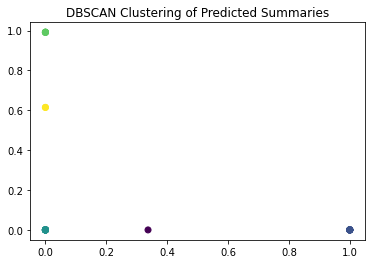


2D List of Clusters:
Cluster 0: ['dog loves', 'dog loves', 'dog loves', 'dog loves', 'dog loves', 'dog loves', 'dog loves', 'dog loves', 'dog loves', 'dog loves', 'dog loves', 'dog loves']
Cluster 1: ['love', 'dogs love', 'great product', 'great deal', 'great food', 'delicious', 'dogs love', 'great product', 'dogs love', 'great deal', 'great flavor', 'vegetarian', 'great product', 'rip', 'dogs love', 'great product']
Cluster 2: ['good', 'good', 'good', 'good', 'good']
Cluster 3: ['good value', 'good price']
Cluster -1: ['puppy loves']


In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

# Create a TF-IDF matrix for the summaries
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(predicted_summaries)

# Reduce dimensionality for visualization
lsa = TruncatedSVD(n_components=2)
X_reduced = lsa.fit_transform(X)

# Apply DBSCAN
dbscan = DBSCAN(eps=0.2, min_samples=2)
predicted_clusters = dbscan.fit_predict(X_reduced)

# Print the predicted clusters
print("Predicted Clusters:")
cluster_info = []
for cluster_id in set(predicted_clusters):
    cluster_indices = [i for i, cluster in enumerate(predicted_clusters) if cluster == cluster_id]
    cluster_summaries = [predicted_summaries[i] for i in cluster_indices]
    
    cluster_info.append({
        "Cluster": cluster_id,
        "Summaries": cluster_summaries
    })

    print(f"Cluster {cluster_id}: {', '.join(cluster_summaries)}")

# Plot the clusters
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=predicted_clusters, cmap='viridis')
plt.title('DBSCAN Clustering of Predicted Summaries')
plt.show()

# Print the 2D list of clusters
print("\n2D List of Clusters:")
for info in cluster_info:
    print(f"Cluster {info['Cluster']}: {info['Summaries']}")


In [62]:
for info in cluster_info:
    summarize(" ".join(info['Summaries']))


Original Review: dog loves dog loves dog loves dog loves dog loves dog loves dog loves dog loves dog loves dog loves dog loves dog loves
Predicted Summary:  dog loves



Original Review: love dogs love great product great deal great food delicious dogs love great product dogs love great deal great flavor vegetarian great product rip dogs love great product
Predicted Summary:  great product



Original Review: good good good good good
Predicted Summary:  good



Original Review: good value good price
Predicted Summary:  good value



Original Review: puppy loves
Predicted Summary:  great puppy





## Next step: Converting shortened summaries to 1-3 human-like sentences

In [ ]:
final_summaries = ["dog loves", "great product", "good value", "great puppy"]

#ideal output is something like "Customers like this product since their dogs love it, and it has great value."